In [1]:
import random
import numpy as np
import shapely
from shapely.geometry import Point, LineString
from matplotlib import pyplot as plt
import anytree
from IPython.display import IFrame
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import osmnx as ox
import pandas as pd
import geopandas as gpd
ox.config(use_cache=True, log_console=False)
from descartes import PolygonPatch
from sklearn.datasets import make_blobs

/home/centrogeo/anaconda3/envs/ulises/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Usando la bilioteca osmnx que es una API para usar *Open Street Maps*  podemos obtener todos los nodos de la gráfica de de la red de autos en los siguientes municipios

In [2]:
G_1 = ox.graph_from_place("Cuernavaca, Morelos, Mexico", network_type="drive",)
G_2 = ox.graph_from_place("Jiutepec, Morelos, Mexico", network_type="drive",)
G_3 = ox.graph_from_place("Temixco, Morelos, Mexico", network_type="drive",)
G_4 = ox.graph_from_place("Xochitepec, Morelos, Mexico", network_type="drive",)
G_5 = ox.graph_from_place("Emiliano Zapata, Morelos, Mexico", network_type="drive",)

Obtengamos el poligono del municipio de Cuernavaca

In [3]:
#gdf = ox.geocode_to_gdf("Cuernavaca, Morelos, Mexico")
#gdf.head()
gdf = ox.geocode_to_gdf("cdmx, Mexico")
gdf.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-99.36492 19.27777, -99.36192 19.275...",19.592757,19.048719,-98.940303,-99.364924,258281399,relation,1376330,19.43263,-99.133178,"Mexico City, Mexico",boundary,administrative,0.949924


<AxesSubplot:>

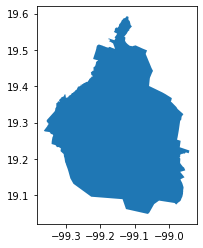

In [4]:
gdf.plot()

A partir de las gráficas que tenemos vamos a extraer solo los nodos y vamos a juntarlos todos en un geodataframe

In [5]:
G_1

In [6]:
xy = []
for G in [G_1, G_2, G_3, G_4, G_5 ]:
    xy= xy + [(data['x'], data['y']) for node, data in G.nodes(data=True)] 

In [7]:
x, y = list(zip(*xy))

In [9]:
#gdf_nodos = gpd.GeoDataFrame(data={'x':x, 'y':y})
#gdf_nodos.crs = gdf.crs
#gdf_nodos.name = 'nodes'
#gdf_nodos['geometry'] = gdf_nodos.apply(lambda row: Point((row['x'], row['y'])), axis=1)
#gdf_nodos.head()

gdf_nodos =  pd.read_pickle('escuelas_centroides.pkl')
#escuelas.plot()
gdf_nodos = gdf_nodos.to_crs(gdf.crs)
gdf_nodos['x'] = gdf_nodos['geometry'].x
gdf_nodos['y'] = gdf_nodos['geometry'].y

gdf_nodos.head()

,id_escuela,geometry,area,x,y
0,0,POINT (-99.10427 19.30971),12.546194,-99.104274,19.309708
1,1,POINT (-99.09848 19.39481),12.546194,-99.098483,19.394807
2,2,POINT (-99.13486 19.46192),12.546194,-99.134863,19.461921
3,3,POINT (-99.14904 19.44519),12.546194,-99.149043,19.445188
4,4,POINT (-99.30897 19.35199),12.546194,-99.308974,19.351992


In [10]:
gdf_nodos.shape

(1494, 5)

<AxesSubplot:>

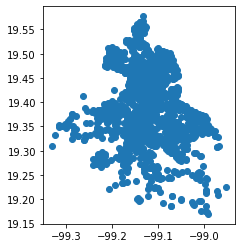

In [11]:
gdf_nodos.plot()

Vamos a crear un mapa que contenga a los puntos y al polygono del municipio de cuernavaca

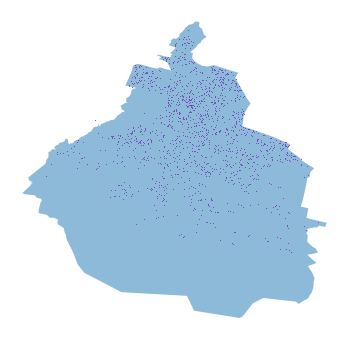

In [12]:
o_val, s_val, e_val, n_val = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))

x_pol, y_pol = gdf['geometry'][0].exterior.xy
ax.fill (x_pol, y_pol, alpha=0.5)
ax.scatter(x=gdf_nodos['x'], y=gdf_nodos['y'], s=1, c='m', linewidth=0, zorder=1)



ax.axis('off')
plt.show()

¿ Como tendríamos que hacer para intersectar el poligono con los puntos ?

In [13]:
%%time
res_bool = gdf_nodos['geometry'].apply(lambda l: gdf['geometry'][0].contains(l))

CPU times: user 930 ms, sys: 4.18 ms, total: 934 ms
Wall time: 932 ms


In [14]:
gdf_nodos[res_bool]

,id_escuela,geometry,area,x,y
0,0,POINT (-99.10427 19.30971),12.546194,-99.104274,19.309708
1,1,POINT (-99.09848 19.39481),12.546194,-99.098483,19.394807
2,2,POINT (-99.13486 19.46192),12.546194,-99.134863,19.461921
3,3,POINT (-99.14904 19.44519),12.546194,-99.149043,19.445188
4,4,POINT (-99.30897 19.35199),12.546194,-99.308974,19.351992
...,...,...,...,...,...
1577,2377,POINT (-99.04335 19.39215),12.546194,-99.043345,19.392145
1578,2379,POINT (-99.10528 19.46527),12.546194,-99.105278,19.465275
1579,2380,POINT (-99.19083 19.28649),12.546194,-99.190826,19.286488
1580,2381,POINT (-99.19038 19.48874),12.546194,-99.190378,19.488739


Vamos hacerlo con un índice espacial en geopandas 

In [15]:
sindex = gdf_nodos.sindex


Veamos que es este indice espacial

In [16]:
sindex

Tomemos ahora la interseccion entre el índice y el bounding box del poligono 

In [17]:
index_intersec_bounds = sindex.intersection(gdf['geometry'][0].bounds)
index_intersec_bounds

array([1135,  270,  552, ..., 1391, 1038,   63])

In [19]:
possible_matches_index = list(index_intersec_bounds)
#possible_matches_index

Obtenemos los puntos que se intersectan y vemos aquellos que se intersecten con la geometria del poligono

In [20]:
possible_matches = gdf_nodos.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(gdf['geometry'][0])]####Comparacion con el poligono

In [21]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodos[~gdf_nodos.isin(points_within_geometry)]

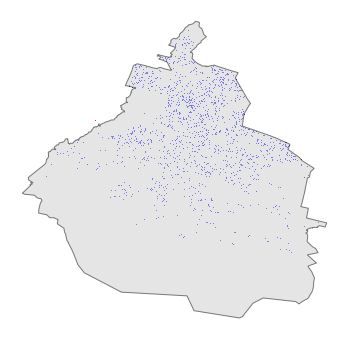

In [22]:
fig, ax = plt.subplots(figsize=(6,6))

patch = PolygonPatch(gdf['geometry'][0], fc='#cccccc', ec='k', alpha=0.5, zorder=3)
ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    

ax.axis('off')
plt.show()

In [23]:
points_within_geometry.shape

(1491, 5)

In [24]:
points_outside_geometry.shape

(1494, 5)

Podemos incluso dividir nuestro poligono para obtener las intersecciones internas y poder hacer una comparación con los nodos de la red 

In [25]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(gdf['geometry'][0], quadrat_width=0.01)

In [26]:
type(geometry_cut)

shapely.geometry.multipolygon.MultiPolygon

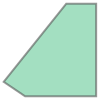

In [27]:
geometry_cut[0]

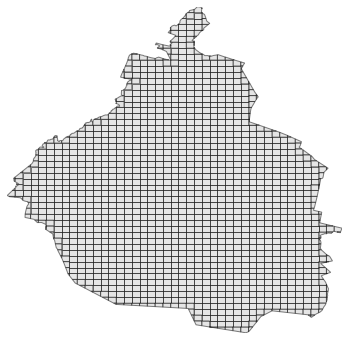

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(o_val, e_val)
ax.set_ylim(s_val, n_val)
ax.axis('off')

plt.show()

In [29]:
points_within_geometry_df = pd.DataFrame()
count_dics =[]
for poly in geometry_cut:   
    poly = poly.buffer(1e-14).buffer(0)
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf_nodos.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    count_dics.append({'geometry': poly ,'Puntos_dentro':precise_matches.shape[0] })
    points_within_geometry_df = points_within_geometry_df.append(precise_matches)

In [30]:
points_within_geometry_df

,id_escuela,geometry,area,x,y
198,289,POINT (-99.32569 19.33146),12.546194,-99.325695,19.331462
434,636,POINT (-99.33224 19.30989),12.546194,-99.332237,19.309885
1243,1847,POINT (-99.31719 19.34899),12.546194,-99.317194,19.348992
125,181,POINT (-99.31642 19.35369),12.546194,-99.316415,19.353688
1426,2123,POINT (-99.31236 19.35159),12.546194,-99.312360,19.351593
...,...,...,...,...,...
1403,2093,POINT (-99.20863 19.49214),12.546194,-99.208627,19.492138
1536,2305,POINT (-99.20717 19.50211),12.546194,-99.207172,19.502112
433,635,POINT (-99.20801 19.50276),12.546194,-99.208011,19.502764
298,434,POINT (-99.20749 19.50871),12.546194,-99.207488,19.508706


In [31]:
df_polygons= gpd.GeoDataFrame(count_dics)

<AxesSubplot:>

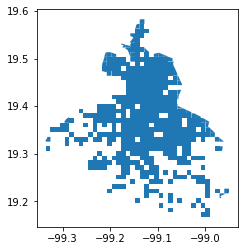

In [32]:
df_polygons[df_polygons['Puntos_dentro']!=0].plot()

In [33]:
points_within_geometry_df = points_within_geometry_df.drop_duplicates(subset=['x', 'y'])
points_outside_geometry_df = gdf_nodos[~gdf_nodos.isin(points_within_geometry_df)]

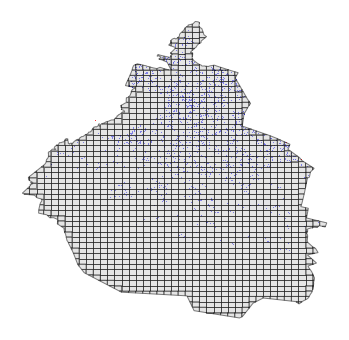

In [38]:

fig, ax = plt.subplots(figsize=(6,6))

for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry_df['x'], y=points_outside_geometry_df['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry_df['x'], y=points_within_geometry_df['y'], s=1, c='b', linewidth=0, zorder=2)
    

ax.axis('off')
plt.show()

¿ Cuando nos sirve tener la segunda versión?